In [41]:
import test_data_preparation
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import models
import jax.numpy as jnp

plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.5

CROP_SIZE = 64

In [38]:
test_ds = test_data_preparation.get_test_dataset("div2k", batch_size=1)
test_ds = iter(test_ds)

In [81]:
test_im_rgb = next(test_ds)

In [82]:
def random_crop(low_res_img, high_res_img, low_res_crop_size, super_res_factor):
    """
    Return random crop from image for data augmentation, as done in original paper.
    Based on example found at: https://keras.io/examples/vision/edsr/
    """
    high_res_crop_size = low_res_crop_size * super_res_factor
    low_res_img_shape = tf.shape(low_res_img)[:2]  # Of shape (height, width)

    low_res_width = tf.random.uniform(shape=(), maxval=low_res_img_shape[1] - low_res_crop_size + 1, dtype=tf.int32)
    low_res_height = tf.random.uniform(shape=(), maxval=low_res_img_shape[0] - low_res_crop_size + 1, dtype=tf.int32)

    high_res_width = low_res_width * super_res_factor
    high_res_height = low_res_height * super_res_factor

    low_res_img_cropped = low_res_img[
                          low_res_height: low_res_height + low_res_crop_size,
                          low_res_width: low_res_width + low_res_crop_size,
                          ]
    high_res_img_cropped = high_res_img[
                           high_res_height: high_res_height + high_res_crop_size,
                           high_res_width: high_res_width + high_res_crop_size,
                           ]
    return low_res_img_cropped, high_res_img_cropped, low_res_width, low_res_height

In [111]:
def plot_crop_comparisons_and_full(test_im_rgb):
    low_res_crop, high_res_crop, crop_x, crop_y = random_crop(test_im_rgb.lr[0], test_im_rgb.hr[0], 64, 2)
    print(f"crop_x: {crop_x} crop_y: {crop_y}")
    im_width = test_im_rgb.lr[0].shape[1]
    im_height = test_im_rgb.lr[0].shape[0]
    bbox = jnp.array([crop_y/im_height, crop_x/im_width, (crop_y+CROP_SIZE)/im_height, (crop_x+CROP_SIZE)/im_width])
    bbox = bbox[jnp.newaxis,...][jnp.newaxis,...]
    low_res_crop = low_res_crop[jnp.newaxis, ...]
    high_res_crop = high_res_crop[jnp.newaxis, ...]

    m3_network = models.model.Model(network="M3", should_collapse=True)
    m3_params = jnp.load("pruning_params/pruning_iter_1_params.npz", allow_pickle=True)
    m3_params = m3_params['arr_0'].item(0)
    m3_mask = jnp.load("pruning_params/pruning_iter_1_mask.npz", allow_pickle=True)
    m3_mask = m3_mask['arr_0'].item(0)
    m3_model_upscaled_image = test_data_preparation.upscale_image_with_model(low_res_crop, m3_network, m3_params, m3_mask)[0]/255

    m3_pruned_params = jnp.load("pruning_params/pruning_iter_10_params.npz", allow_pickle=True)
    m3_pruned_params = m3_pruned_params['arr_0'].item(0)
    m3_pruned_mask = jnp.load("pruning_params/pruning_iter_10_mask.npz", allow_pickle=True)
    m3_pruned_mask = m3_pruned_mask['arr_0'].item(0)
    m3_pruned_model_upscaled_image = test_data_preparation.upscale_image_with_model(low_res_crop, m3_network, m3_pruned_params, m3_pruned_mask)[0]/255

    full_low_res = test_data_preparation.ycbcr_to_rgb(test_data_preparation.rgb_to_ycbcr(test_im_rgb.lr[0]))/255
    full_low_res = tf.image.draw_bounding_boxes(full_low_res[jnp.newaxis,...], bbox, colors=jnp.array([[1.0,0.0,0.0]]))[0]
    low_res_plot = test_data_preparation.ycbcr_to_rgb(test_data_preparation.rgb_to_ycbcr(low_res_crop[0]))/255
    high_res_plot = test_data_preparation.ycbcr_to_rgb(test_data_preparation.rgb_to_ycbcr(high_res_crop[0]))/255
    bicubic = tf.image.resize(low_res_plot, (2 * low_res_plot.shape[0], 2 * low_res_plot.shape[1]), method="bicubic")

    figure_mosaic = """
    GGG
    GGG
    ABC
    DEF
    """

    # fig, (row1, row2) = plt.subplots(2, 3, figsize=(14, 12))
    fig, axes = plt.subplot_mosaic(mosaic=figure_mosaic, figsize=(14, 12))
    axes["G"].imshow(full_low_res)
    axes["G"].set_xlabel("Full Image")
    axes["A"].imshow(low_res_plot)
    axes["A"].set_xlabel("Low Resolution")
    axes["B"].imshow(high_res_plot)
    axes["B"].set_xlabel("High Resolution")
    axes["C"].imshow(bicubic)
    axes["C"].set_xlabel("Bicubic Upscaled")
    axes["D"].imshow(m3_model_upscaled_image)
    axes["D"].set_xlabel("Model Upscaled")
    axes["E"].imshow(m3_pruned_model_upscaled_image)
    axes["E"].set_xlabel("Pruned Model Upscaled")
    axes["F"].axis("off")
    fig.tight_layout()

In [182]:
def plot_crop_comparisons(test_im_rgb):
    low_res_crop, high_res_crop, crop_x, crop_y = random_crop(test_im_rgb.lr[0], test_im_rgb.hr[0], 64, 2)
    print(f"crop_x: {crop_x} crop_y: {crop_y}")
    low_res_crop = low_res_crop[jnp.newaxis, ...]
    high_res_crop = high_res_crop[jnp.newaxis, ...]

    m3_network = models.model.Model(network="M3", should_collapse=True)
    m3_params = jnp.load("pruning_params/pruning_iter_1_params.npz", allow_pickle=True)
    m3_params = m3_params['arr_0'].item(0)
    m3_mask = jnp.load("pruning_params/pruning_iter_1_mask.npz", allow_pickle=True)
    m3_mask = m3_mask['arr_0'].item(0)
    m3_model_upscaled_image = test_data_preparation.upscale_image_with_model(low_res_crop, m3_network, m3_params, m3_mask)[0]/255

    m3_pruned_params = jnp.load("pruning_params/pruning_iter_10_params.npz", allow_pickle=True)
    m3_pruned_params = m3_pruned_params['arr_0'].item(0)
    m3_pruned_mask = jnp.load("pruning_params/pruning_iter_10_mask.npz", allow_pickle=True)
    m3_pruned_mask = m3_pruned_mask['arr_0'].item(0)
    m3_pruned_model_upscaled_image = test_data_preparation.upscale_image_with_model(low_res_crop, m3_network, m3_pruned_params, m3_pruned_mask)[0]/255

    low_res_plot = test_data_preparation.ycbcr_to_rgb(test_data_preparation.rgb_to_ycbcr(low_res_crop[0]))/255
    high_res_plot = test_data_preparation.ycbcr_to_rgb(test_data_preparation.rgb_to_ycbcr(high_res_crop[0]))/255
    bicubic = tf.image.resize(low_res_plot, (2 * low_res_plot.shape[0], 2 * low_res_plot.shape[1]), method="bicubic")

    figure_mosaic = """
    ABC
    DEF
    """

    # fig, (row1, row2) = plt.subplots(2, 3, figsize=(14, 12))
    fig, axes = plt.subplot_mosaic(mosaic=figure_mosaic, figsize=(14, 10))
    axes["A"].imshow(low_res_plot)
    axes["A"].set_xlabel("Low Resolution")
    axes["B"].imshow(high_res_plot)
    axes["B"].set_xlabel("Ground Truth High Resolution")
    axes["C"].imshow(bicubic)
    axes["C"].set_xlabel("Bicubic Upscaled")
    axes["D"].imshow(m3_model_upscaled_image)
    axes["D"].set_xlabel("M3 Model (20\% Pruned) Upscaled")
    axes["E"].imshow(m3_pruned_model_upscaled_image)
    axes["E"].set_xlabel("M3 Model (89.3\% Pruned) Upscaled")
    axes["F"].axis("off")
    # fig.tight_layout()
    plt.savefig("crop_comparison.png", dpi=200)

In [185]:
def plot_full_img(test_im_rgb, crop_x, crop_y):
    im_width = test_im_rgb.lr[0].shape[1]
    im_height = test_im_rgb.lr[0].shape[0]
    bbox = jnp.array([crop_y/im_height, crop_x/im_width, (crop_y+CROP_SIZE)/im_height, (crop_x+CROP_SIZE)/im_width])
    bbox = bbox[jnp.newaxis,...][jnp.newaxis,...]

    full_low_res = test_data_preparation.ycbcr_to_rgb(test_data_preparation.rgb_to_ycbcr(test_im_rgb.lr[0]))/255
    full_low_res = tf.image.draw_bounding_boxes(full_low_res[jnp.newaxis,...], bbox, colors=jnp.array([[1.0,0.0,0.0]]))[0]

    fig, ax = plt.subplots(figsize=(10,8))
    ax.imshow(full_low_res)
    ax.set_xlabel("Full Image")
    plt.savefig("full_image.png", dpi=200)

Below are some examples of upscaled images. The upscaling is performed on crops of the original images, which have been drawn out with a bounding box.

### Castle

crop_x: 555 crop_y: 395


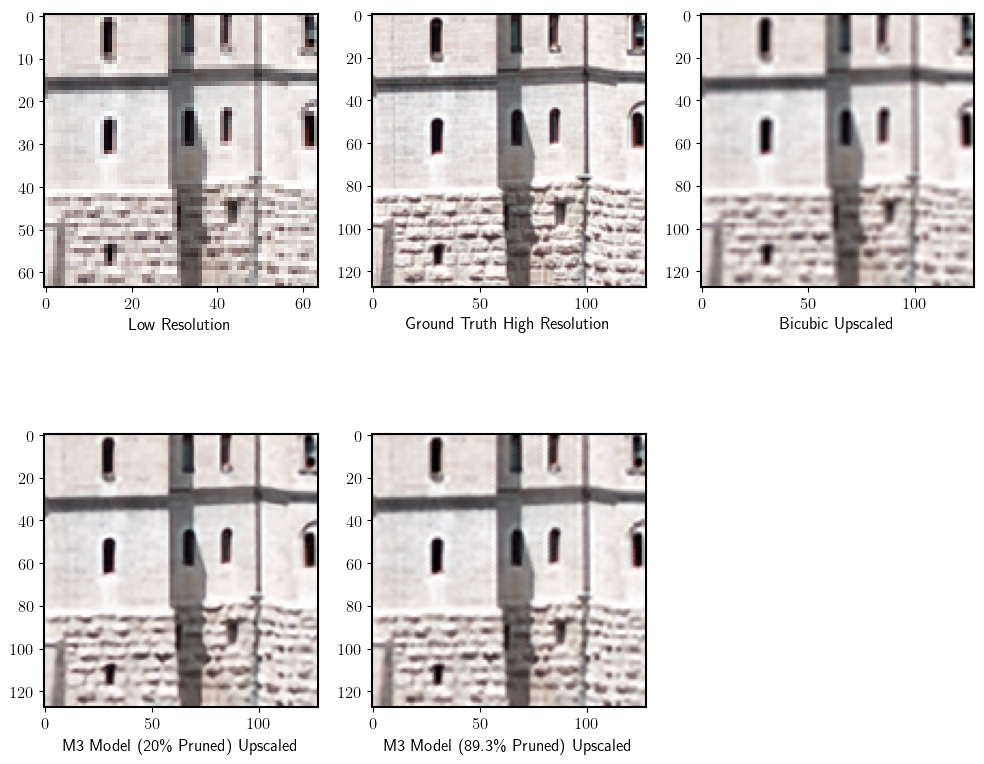

In [153]:
plot_crop_comparisons(test_im_rgb)

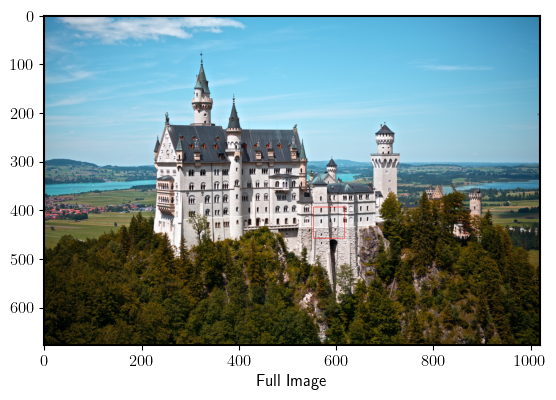

In [156]:
plot_full_img(test_im_rgb, 555, 395)

### Crocodile

In [175]:
test_im_rgb = next(test_ds)

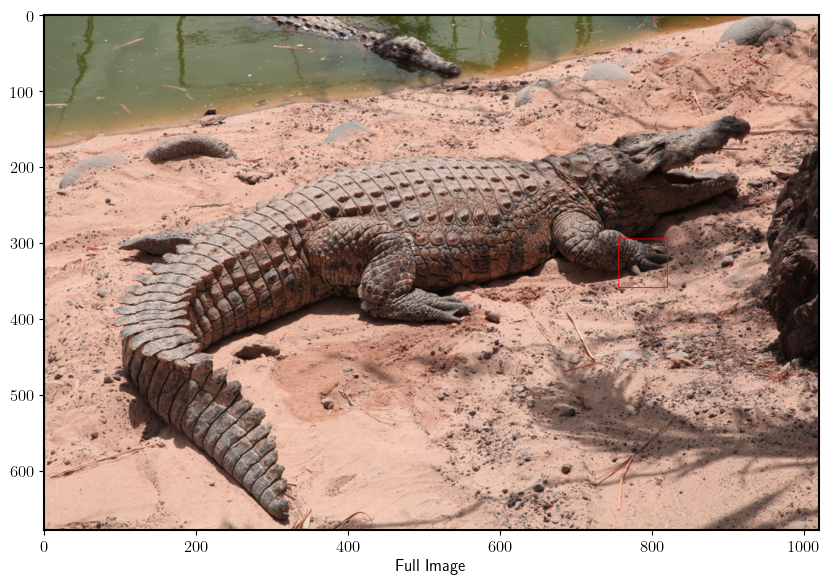

In [209]:
plot_full_img(test_im_rgb, 757, 296)

crop_x: 757 crop_y: 296


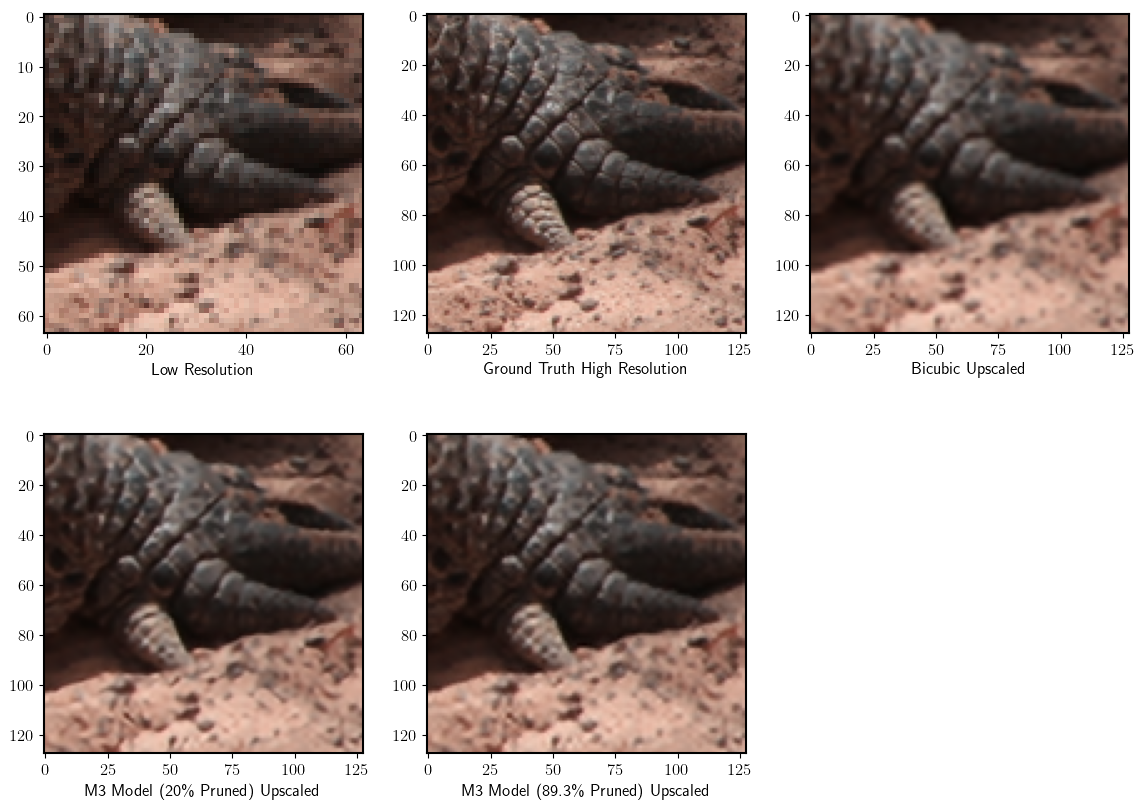

In [207]:
plot_crop_comparisons(test_im_rgb)

### Food

The difference in the more aggressively pruned model is more visible here

In [215]:
test_im_rgb = next(test_ds)

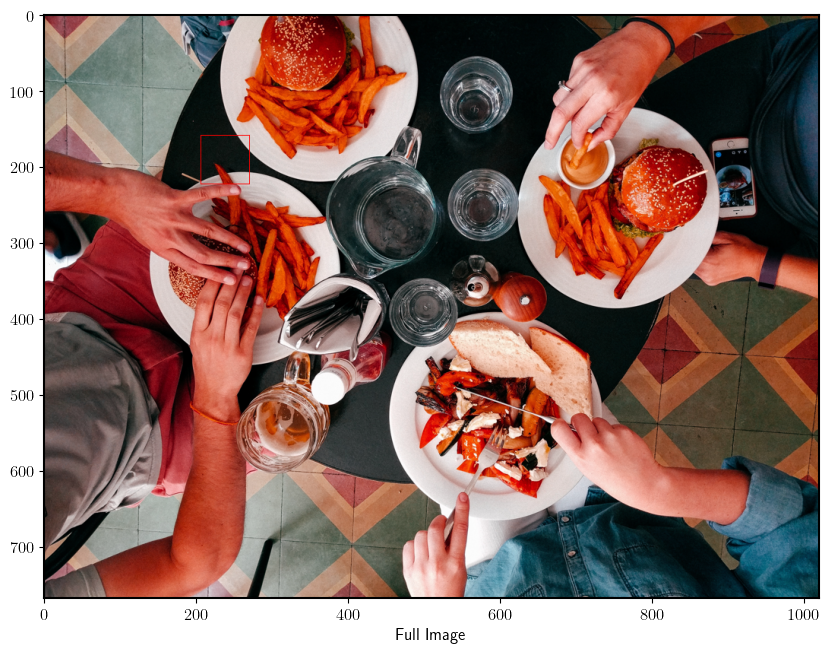

In [218]:
plot_full_img(test_im_rgb, 207, 160)

crop_x: 207 crop_y: 160


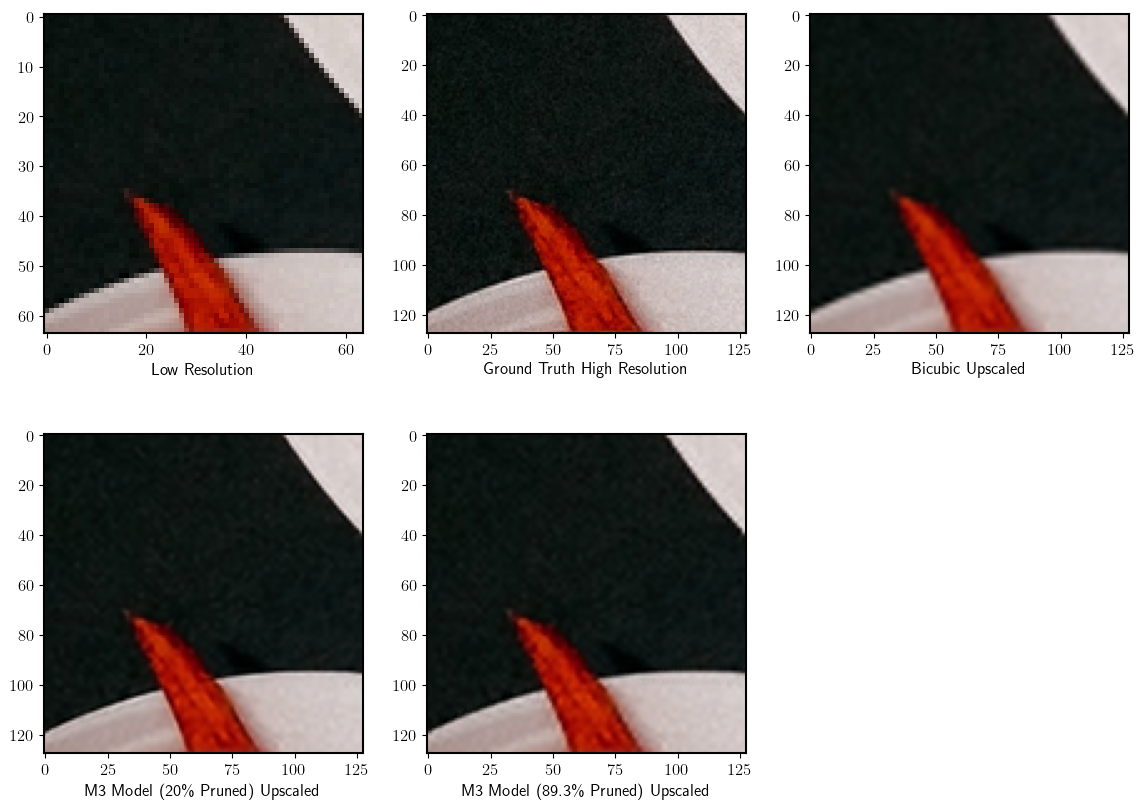

In [217]:
plot_crop_comparisons(test_im_rgb)